In [1]:
import os
import time
import glob
from dotenv import load_dotenv
from datetime import datetime
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.stats as sp
from scipy.stats import spearmanr

import tensorflow as tf
from keras import backend
from keras import optimizers
from keras.callbacks import Callback
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Reshape, Dropout, \
                        Input, merge, AtrousConvolution1D, Activation, Conv2D, Multiply, Add
from keras.layers.normalization import BatchNormalization
from keras.utils import multi_gpu_model
from sklearn.decomposition import PCA
from IPython.core.debugger import Pdb #Pdb().set_trace()
#from hyperdash import Experiment

import utils

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chikazoe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_DIR = './dataset/'
RESULT_DIR = './results/'
WEIGHT_FILE = 'weights.h5'
LOSS_CURVE_IMAGE_FILE = 'losscurve.jpg'
SCATTER_PLOT_IMAGE_FILE = 'predict.jpg'
CORRELATION_CURVE_IMAGE_FILE = 'correlation_curve.jpg'

## Hyperparameter

In [3]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE=1e-4
use_optimizer = 'Adam' #'SGD', 'Adam'
model_name = 'AMPFECNN' #'spotify_cnn', 'wavenet', 'AMPFECNN'
label_name = 'listens' #'listens',  'interest', 'favorites', 'pca_listen_favorites'
use_mfcc = True
data_size = 'large' #'small', 'large'

## Load Data

### Load features

In [4]:
dotenv_path = os.getcwd()+'/.env'
load_dotenv(dotenv_path)
if data_size == 'small':
    AUDIO_DIR = os.environ.get('AUDIO_DIR_SMALL')
elif data_size == 'large':
    AUDIO_DIR = os.environ.get('AUDIO_DIR_LARGE')

tracks = utils.load('tracks.csv')
features = utils.load('features.csv')

subset = tracks.index[tracks['set', 'subset'] <= data_size]
tracks = tracks.loc[subset]

In [5]:
train_data_index = tracks.index[tracks['set', 'split'] == 'training']
val_data_index = tracks.index[tracks['set', 'split'] == 'validation']
test_data_index = tracks.index[tracks['set', 'split'] == 'test']

print(' {} training data\n {} validation data\n {} testing data'.format(*map(len, [train_data_index, val_data_index, test_data_index])))

 84353 training data
 10958 validation data
 11263 testing data


### Load labels

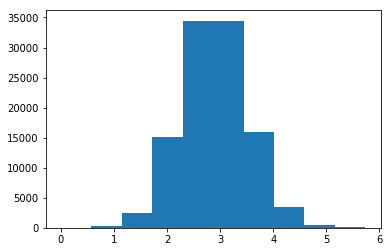

,listens
count,106573.000000
mean,2.891231
std,0.622367
min,0.000000
25%,2.465383
50%,2.883093
75%,3.304921
max,5.735001


In [6]:
if label_name == 'listens' or label_name == 'interest' or label_name == 'favorites':
    labels = tracks['track', label_name]
    labels = pd.DataFrame(labels, index=tracks.index)
    #listens_log = labels['track'] # logを使用する場合にコメントアウトする
    labels = labels[labels['track'][label_name] != 0] # not-logの場合にコメントアウトする
    listens_log = np.log10(labels['track'][label_name].values) # not-logの場合にコメントアウトする
    plt.hist(listens_log) # not-logの場合にコメントアウトする
    plt.show() # not-logの場合にコメントアウトする
    labels_log = pd.DataFrame(listens_log, index=labels.index, columns=[label_name])
    ipd.display(labels_log.describe())
    
    if label_name == 'favorites':
        train_data_index_new = []
        for data in train_data_index:
            if data in labels_log.index:
                train_data_index_new.append(data)
        val_data_index_new = []
        for data in val_data_index:
            if data in labels_log.index:
                val_data_index_new.append(data)
        test_data_index_new = []
        for data in test_data_index:
            if data in labels_log.index:
                test_data_index_new.append(data)

        train_data_index = pd.Int64Index(train_data_index_new)
        val_data_index = pd.Int64Index(val_data_index_new)
        test_data_index = pd.Int64Index(test_data_index_new)
        print(' {} training data\n {} validation data\n {} testing data'.format(*map(len, [train_data_index, val_data_index, test_data_index])))

elif label_name == 'PCAlistenfavorites':
    weights = tracks['track']['listens']
    heights = tracks['track']['favorites']
    weights_zscore = sp.stats.zscore(weights)
    heights_zscore = sp.stats.zscore(heights)
    pca = PCA(n_components = 1)
    a = pca.fit_transform(np.transpose(np.array([weights_zscore, heights_zscore])))
    plt.hist(a,bins=100)
    plt.show()
    labels_log = pd.DataFrame(a, index=weights.index, columns=[label_name])
    ipd.display(labels_log.describe())

### Load input data

In [7]:
x_train = np.load(DATASET_DIR+data_size+'/train_mfcc.npy')
x_val = np.load(DATASET_DIR+data_size+'/val_mfcc.npy')
x_test = np.load(DATASET_DIR+data_size+'/test_mfcc.npy')
train_subscript = np.load(DATASET_DIR+data_size+'/train_num.npy')
val_subscript = np.load(DATASET_DIR+data_size+'/val_num.npy')
test_subscript = np.load(DATASET_DIR+data_size+'/test_num.npy')
y_train = labels_log.loc[train_data_index[train_subscript]].values.flatten()
y_val = labels_log.loc[val_data_index[val_subscript]].values.flatten()
y_test = labels_log.loc[test_data_index[test_subscript]].values.flatten()
print(' {} training data\n {} validation data\n {} testing data'.format(*map(len, [y_train, y_val, y_test])))

 81363 training data
 10676 validation data
 10922 testing data


## Design model

#### Spotify CNN
* Architecture: [End-to-end learning for music audio](http://www.mirlab.org/conference_papers/International_Conference/ICASSP%202014/papers/p7014-dieleman.pdf), Sander Dieleman, Benjamin Schrauwen.
* Missing: track segmentation and class averaging (majority voting)
* Compared with log-scaled mel-spectrograms instead of strided convolution as first layer.
* Larger net: http://benanne.github.io/2014/08/05/spotify-cnns.html

In [8]:
def design_spotify_model():
    backend.clear_session()
    
    # Original model
    model = Sequential()
    model.add(Reshape((-1, 1), input_shape=loader.shape))
    model.add(Conv1D(128, 512, strides=512, activation='relu'))

    model.add(Conv1D(32, 8, activation='relu'))
    model.add(MaxPooling1D(4))

    model.add(Conv1D(32, 8, activation='relu'))
    model.add(MaxPooling1D(4))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(1))

    # Add layer
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))

    # Freeze layer
    print('Freeze layer')
    for i,layer in enumerate(model.layers[:8]):
        print(i,':',layer.name)
        layer.trainable = False
        
    model.summary()
    
    return model

#### Wavenet
[keras-wavenet](https://github.com/usernaamee/keras-wavenet)

In [9]:
def wavenetBlock(n_atrous_filters, atrous_filter_size, atrous_rate):
    def f(input_):
        residual = input_
        tanh_out = AtrousConvolution1D(n_atrous_filters, atrous_filter_size,
                                       atrous_rate=atrous_rate,
                                       border_mode='same',
                                       activation='tanh')(input_)
        sigmoid_out = AtrousConvolution1D(n_atrous_filters, atrous_filter_size,
                                          atrous_rate=atrous_rate,
                                          border_mode='same',
                                          activation='sigmoid')(input_)
        merged = merge([tanh_out, sigmoid_out], mode='mul')
        skip_out = Conv1D(1, 1, activation='relu', border_mode='same')(merged)
        out = merge([skip_out, residual], mode='sum')
        return out, skip_out
    return f

In [10]:
# simple-generative-model
def get_basic_generative_model():
    input_ = Input(shape=(loader.shape[0], 1))
    A, B = wavenetBlock(64, 2, 2)(input_)
    skip_connections = [B]
    for i in range(20):
        A, B = wavenetBlock(64, 2, 2**((i+2)%9))(A)
        skip_connections.append(B)
    net = merge(skip_connections, mode='sum')
    net = Activation('relu')(net)
    net = Conv1D(1, 1, activation='relu')(net)
    net = Conv1D(1, 1)(net)
    net = Flatten()(net)
    net = Dense(256, activation='relu')(net)
    
    net = Dense(256, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(0.5)(net)
    net = Dense(256, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(0.5)(net)
    net = Dense(1)(net)
    
    model = Model(input=input_, output=net)

    for i,layer in enumerate(model.layers[:111]):
        print(i,':',layer.name)
        layer.trainable = False
    
    model.summary()
    return model

In [11]:
# simple-generative-model-regressor
def get_basic_generative_model():
    input_size = loader.shape[0]
    input_ = Input(shape=(1, input_size, 1))
    l1a, l1b = wavenetBlock(10, 5, 2)(input_) # ValueError: Input 0 is incompatible with layer conv1d_71: expected ndim=3, found ndim=4
    l2a, l2b = wavenetBlock(1, 2, 4)(l1a)
    l3a, l3b = wavenetBlock(1, 2, 8)(l2a)
    l4a, l4b = wavenetBlock(1, 2, 16)(l3a)
    l5a, l5b = wavenetBlock(1, 2, 3)(l4a)
    l6 = merge([l1b, l2b, l3b, l4b, l5b], mode='sum')
    l7 = Lambda(relu)(l6)
    l8 = Convolution2D(1, 1, 1, activation='relu')(l7)
    l9 = Convolution2D(1, 1, 1)(l8)
    l10 = Flatten()(l9)
    #l11 = Dense(1, activation='tanh')(l10)
    
    net = Dense(256, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(0.5)(net)
    net = Dense(256, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(0.5)(net)
    net = Dense(1)(net)
    
    model = Model(input=input_, output=l11)
    
    model.summary()
    return model

[sudeepkatakol/Wavenet](https://github.com/sudeepkatakol/Wavenet)

In [12]:
def createWavenet(input_shape):
    dilation_channels = 64
    causal_channels = 32
    dilation_kernel = 2

    def residual_block(X, dilation_rate):
        F = Conv1D(dilation_channels, dilation_kernel, padding='causal', dilation_rate=dilation_rate)(X)
        G = Conv1D(dilation_channels, dilation_kernel, padding='causal', dilation_rate=dilation_rate)(X)
        F = Activation('tanh')(F)
        G = Activation('sigmoid')(G)
        Y = Multiply()([F, G])
        return Y

    causal_kernel = 2
    causal_channels = 32
    dilation_rate = 2
    quantization_channels = 256
    
    X_input = Input(input_shape)
    X = Conv1D(causal_channels, causal_kernel, padding='causal', dilation_rate=1)(X_input)
    Y = residual_block(X, 1)
    S0 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 2)
    S1 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 4)
    S2 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 8)
    S3 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 16)
    S4 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 32)
    S5 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 64)
    S6 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 128)
    S7 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 256)
    S8 = Conv1D(dilation_channels, 1, padding="same")(Y)
    Y = Conv1D(causal_channels, 1, padding="same")(Y)
    X = Add()([X, Y])
    Y = residual_block(X, 512)
    S9 = Conv1D(dilation_channels, 1, padding="same")(Y)
    S = Add()([S0, S1, S2, S3, S4, S5, S6, S7, S8, S9])
    X = Activation('relu')(S)
    X = Conv1D(128, 1, padding="same")(X)
    X = Activation('relu')(X)
    X = Conv1D(256, 1, padding="same")(X)
    X = Activation('softmax')(X)
    
    model = Model(input=X_input, output=X)
    
    model.summary()
    return model

#### ConvNet on MFCC

* Architecture: [Automatic Musical Pattern Feature Extraction Using Convolutional Neural Network](http://www.iaeng.org/publication/IMECS2010/IMECS2010_pp546-550.pdf), Tom LH. Li, Antoni B. Chan and Andy HW. Chun
* Missing: track segmentation and majority voting.
* Best seen: 17.6%

In [13]:
def design_AMPFECNN_model():
    backend.clear_session()

    # Original model
    model = Sequential()
    model.add(Reshape((*x_train[0].shape, 1),  input_shape=x_train[0].shape))
    model.add(Conv2D(3, 13, 10, subsample=(1, 4),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(15, 1, 10, subsample=(1, 4),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Conv2D(65, 1, 10, subsample=(1, 4),kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    model.add(Flatten())
    #model.add(Dense(labels_onehot.shape[1]))

    # Add layer
    model.add(Dense(1000, activation='relu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(500, activation='relu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1,kernel_initializer='he_normal'))
    
    for i,layer in enumerate(model.layers[:8]):
        print(i,':',layer.name)
        layer.trainable = False
    
    model.summary()
    
    return model

In [14]:
if model_name == 'spotify_cnn':
    model = design_spotify_model()
elif model_name == 'wavenet':
    #model = get_basic_generative_model() # in bug 6/8
    model = createWavenet((loader.shape[0], 256)) # in bug 6/20
elif model_name == 'AMPFECNN':
    model = design_AMPFECNN_model()

0 : reshape_1
1 : conv2d_1
2 : activation_1
3 : conv2d_2
4 : activation_2
5 : conv2d_3
6 : activation_3
7 : flatten_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 13, 2582, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 644, 3)         393       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 644, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 159, 15)        465       
_________________________________________________________________
activation_2 (Activation)    (None, 1, 159, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 38, 65)         9815      
________________________

In [15]:
if use_optimizer == 'SGD':
    model.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True), loss='mean_squared_error')
elif use_optimizer == 'Adam':
    model.compile(optimizer=optimizers.Adam(lr=LEARNING_RATE), loss='mean_squared_error')

## Train

In [16]:
class Hyperdash(Callback):
    def __init__(self, entries, exp):
        super(Hyperdash, self).__init__()
        self.entries = entries
        self.exp = exp

    def on_epoch_end(self, epoch, logs=None):
        for entrie in self.entries:
            log = logs.get(entrie)
            if log is not None:
                self.exp.metric(entrie, log)

In [17]:
def create_loss_curve(train_loss,val_loss):
    # Set background color or white
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    # Plot loss curve
    plt.plot(train_loss, "o-", label="train_loss", )
    plt.plot(val_loss, "o-", label="val_loss")
    now = datetime.now()
    plt.title(now.strftime('%Y-%m-%d %H:%M ')+' loss curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim(0)
    plt.ylim(0, max(max(train_loss), max(val_loss)))
    plt.legend(loc='upper right')
    plt.grid()
    plt.savefig(RESULT_DIR + LOSS_CURVE_IMAGE_FILE, dpi=100)
    plt.show()

In [18]:
def create_correlationcoefficient_curve(train_corr_list, val_corr_list, last_epoch):
    # Plot correlation curve
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(range(last_epoch), train_corr_list, 'bo-', label='train_correlation')
    plt.plot(range(last_epoch), val_corr_list, 'yo-', label='val_correlation')
    now = datetime.now()
    plt.title(now.strftime('%Y-%m-%d %H:%M ') + ' correlation curve ')
    plt.xlabel('epoch')
    plt.ylabel('correlation coefficient')
    plt.xlim(0)
    plt.yticks(np.arange(-0.5, 1.0, 0.1))
    plt.legend(loc='lower left')
    plt.grid()
    plt.savefig(RESULT_DIR + CORRELATION_CURVE_IMAGE_FILE, dpi=100)
    plt.show()

In [19]:
def create_scatter_plot(correlation_coefficient, predict_value, true_value, title):
    # Set background color to white
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    # Plot predict_value and true_value
    plt.plot(predict_value, true_value, "o")
    now = datetime.now()
    plt.title(now.strftime('%Y-%m-%d %H:%M ')+title+' r='+str(correlation_coefficient)[:6])
    plt.xlabel('predict value')
    plt.ylabel('true value')
    plt.xlim(min(predict_value), max(predict_value))
    plt.ylim(min(true_value), max(true_value))
    plt.savefig(RESULT_DIR+title+SCATTER_PLOT_IMAGE_FILE, dpi=100)
    plt.show()

In [20]:
train_loss_list = []
val_loss_list = []
train_corr_list = []
val_corr_list = []
print('All Epochs:', EPOCHS)
for epoch in range(EPOCHS):
    #exp = Experiment('Spotify CNN')
    #hd_callback = Hyperdash(['loss', 'val_loss'], exp)
    start = time.time()
    history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=epoch+1, verbose=1, 
        callbacks=None, validation_data=(x_val,y_val), shuffle=True, initial_epoch=epoch)
    train_loss_list.append(history.history['loss'][0])
    val_loss_list.append(history.history['val_loss'][0])
    
    predict_train = model.predict(x_train, batch_size=1, verbose=1)
    train_correlation_coefficient = spearmanr(predict_train.flatten(), y_train)[0]
    predict_val = model.predict(x_val, batch_size=1, verbose=1)
    val_correlation_coefficient = spearmanr(predict_val.flatten(), y_val)[0]
    
    if epoch+1 >= 10: 
        if val_correlation_coefficient > max(val_corr_list):
            model.save_weights(os.path.join(RESULT_DIR, 'epoch'+str(epoch+1)+'_'+WEIGHT_FILE))
   
    train_corr_list.append(train_correlation_coefficient)
    val_corr_list.append(val_correlation_coefficient)
    
    end = time.time()
    print('time:%.2fm - train_corr:%.4f - val_corr:%.4f' % ((end - start) / 60, train_correlation_coefficient, val_correlation_coefficient))
               
#exp.end()
print('Finish Training')

All Epochs: 50
Train on 81363 samples, validate on 10676 samples
Epoch 1/1
10676/10676 [==============================] - 32s 3ms/step
time:5.66m - train_corr:0.0341 - val_corr:0.0390
Train on 81363 samples, validate on 10676 samples
Epoch 2/2
10676/10676 [==============================] - 31s 3ms/step
time:5.44m - train_corr:0.0591 - val_corr:0.0618
Train on 81363 samples, validate on 10676 samples
Epoch 3/3
10676/10676 [==============================] - 30s 3ms/step
time:5.16m - train_corr:0.0169 - val_corr:0.0029
Train on 81363 samples, validate on 10676 samples
Epoch 4/4
10676/10676 [==============================] - 30s 3ms/step
time:5.11m - train_corr:0.0621 - val_corr:0.0657
Train on 81363 samples, validate on 10676 samples
Epoch 5/5
10676/10676 [==============================] - 29s 3ms/step
time:5.04m - train_corr:0.0863 - val_corr:0.0916
Train on 81363 samples, validate on 10676 samples
Epoch 6/6
10676/10676 [==============================] - 30s 3ms/step
time:5.04m - train_c

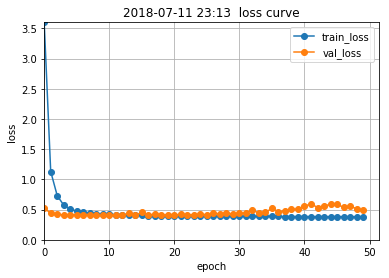

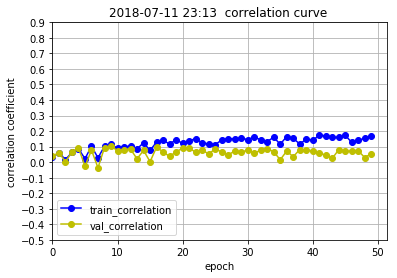

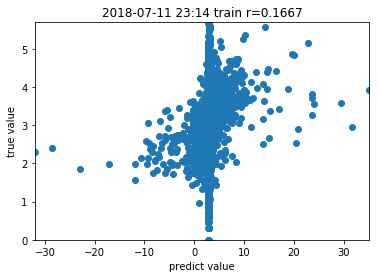

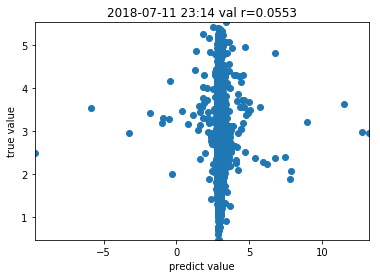

In [21]:
create_loss_curve(train_loss_list, val_loss_list)
create_correlationcoefficient_curve(train_corr_list, val_corr_list,EPOCHS)
create_scatter_plot(train_correlation_coefficient, predict_train.flatten(), y_train, 'train')
create_scatter_plot(val_correlation_coefficient, predict_val.flatten(), y_val, 'val')

## Test

10922/10922 [==============================] - 29s 3ms/step


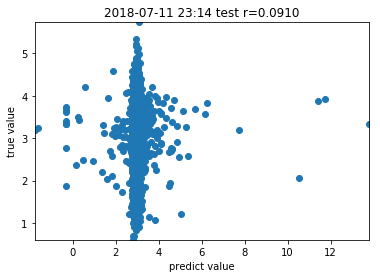

In [22]:
predict_test = model.predict(x_test, batch_size=1, verbose=1)
test_correlation_coefficient = spearmanr(predict_test.flatten(), y_test)[0]
create_scatter_plot(test_correlation_coefficient, predict_test.flatten(), y_test, 'test')

## Save File

In [23]:
#from keras.models import load_model
#model.save('my_model.h5')
#mymodel = load_model('my_model.h5')
model.save_weights(os.path.join(RESULT_DIR, WEIGHT_FILE))

In [24]:
pd.DataFrame(train_loss_list, columns=['train_loss']).to_csv(RESULT_DIR+'train_loss.csv',index=None)
pd.DataFrame(val_loss_list, columns=['val_loss']).to_csv(RESULT_DIR+'val_loss.csv',index=None)
pd.DataFrame(train_corr_list, columns=['train_corr']).to_csv(RESULT_DIR+'train_corr.csv',index=None)
pd.DataFrame(val_corr_list, columns=['val_corr']).to_csv(RESULT_DIR+'val_corr.csv',index=None)

In [25]:
now = datetime.now()
copy_dir = 'results_'+model_name+'_'+label_name+'_'+use_optimizer+ str(LEARNING_RATE)+'_BS'+str(BATCH_SIZE)+'_Ep0-' + str(EPOCHS)+now.strftime('_%Y-%m-%d_%H:%M ')
if not os.path.exists(copy_dir):
    shutil.copytree(RESULT_DIR, copy_dir)
[os.remove(f) for f in glob.glob(RESULT_DIR+'*_weights.h5')]

[None]

## Delete variable

In [26]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                 features| 442495272|
|                   labels|   6948072|
|               labels_log|   6948072|
|              listens_log|    852680|
|             predict_test|     43800|
|            predict_train|    325564|
|              predict_val|     42816|
|                   subset|    852616|
|          test_data_index|     90128|
|           test_subscript|     87472|
|                   tracks| 188347896|
|         train_data_index|    674848|
|          train_subscript|    651000|
|           val_data_index|     87688|
|            val_subscript|     85504|
|                   x_test|2932862944|
|                  x_train|21848243792|
|                    x_val|2866805056|
|                   y_test|     87472|
|                  y_train|    651000|
|                    y_val|     85504|


In [27]:
import gc
del features, tracks
gc.collect()

22361